# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an  example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition
> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for ?

## 2. Data

The data is downloadede from the Kaggle Bluebook for Bulldozers competition:
https://www.kaggle.com/c/bluebook-for-bulldozers/data 

There are 3 main datasets: 

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation 

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation 

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets:
https://docs.google.com/spreadsheets/d/1-Vx3SDlfthLeaxchYIwpJUUqsYRosusbrxuGCKpimzQ/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
!wget https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/data/bluebook-for-bulldozers.zip 

import os
import zipfile

local_zip = 'bluebook-for-bulldozers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('.')
zip_ref.close()

--2021-05-24 08:38:35--  https://github.com/mrdbourke/zero-to-mastery-ml/raw/master/data/bluebook-for-bulldozers.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/bluebook-for-bulldozers.zip [following]
--2021-05-24 08:38:36--  https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/bluebook-for-bulldozers.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72077822 (69M) [application/zip]
Saving to: ‘bluebook-for-bulldozers.zip’

bluebook-for-bulldo 100%[===================>]  68.74M   106MB/s    in 0.6s    

2021-05-24 08:38:37 (106

In [3]:
# Import training and validation sets
df = pd.read_csv('bluebook-for-bulldozers/TrainAndValid.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

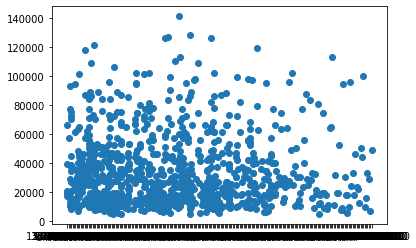

In [6]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [7]:
df.saledate

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

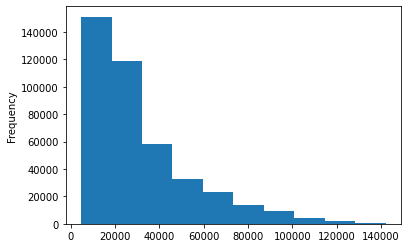

In [8]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [9]:
# Import data again but this time parse dates
df = pd.read_csv('bluebook-for-bulldozers/TrainAndValid.csv',
                 low_memory = False,
                 parse_dates = ["saledate"])

In [10]:
df.saledate.dtype

dtype('<M8[ns]')

In [11]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

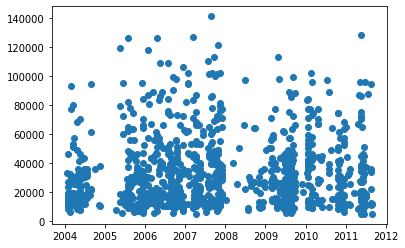

In [12]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [13]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [14]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [15]:
# Sort DataFrame in date order
df.sort_values(by = ["saledate"], inplace = True, ascending = True)

In [16]:
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame


In [17]:
df_tmp = df.copy()

In [18]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


### Add datetime parameters for `saledate` column

In [19]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month 
df_tmp['saleDay'] = df_tmp.saledate.dt.day 
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek 
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [20]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [21]:
# Now we've enriched our DataFrame with date time features, we can remove saledate column
df_tmp.drop("saledate", axis = 1, inplace = True)

In [22]:
# Check the values of different columns 
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

In [23]:
# # Let's build a machine learning model
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs = -1, 
#                               random_state = 42)

# model.fit(df_tmp.drop("SalePrice", axis = 1), df_tmp["SalePrice"])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 1

In [25]:
df_tmp["UsageBand"].dtype

dtype('O')

In [26]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string to categories

One way we can turn all our data into numbers is by converting them into pandas categories.

In [27]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [28]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [29]:
# Find the columns which contains strings
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [30]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    df_tmp[label] = content.astype("category").cat.as_ordered()

In [31]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [32]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [33]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [34]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [35]:
# Export current tmp dataframe
df_tmp.to_csv('bluebook-for-bulldozers/train_tmp.csv',
              index = False)

In [36]:
# Import preprocessed data
df_tmp = pd.read_csv('bluebook-for-bulldozers/train_tmp.csv',
                     low_memory = False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Fill missing values

In [37]:
# Fill numerical missing data
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [38]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [39]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

auctioneerID
MachineHoursCurrentMeter


In [40]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # Add a binary column which tells us if the data was missing or not
      df_tmp[label + "_is_missing"] = pd.isnull(content)
      # Fill missing numeric values with median
      df_tmp[label] = content.fillna(content.median())

In [41]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

In [42]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [43]:
df_tmp.isnull().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [44]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
    print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [45]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
    # Add binary column to indicate whether sample had missing value or not
    df_tmp[label+"is_missing"] = pd.isnull(content)
    # Turn categories into numbers and add +1
    df_tmp[label] = pd.Categorical(content).codes + 1

In [46]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controlsis_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [47]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,...,fiModelSeriesis_missing,fiModelDescriptoris_missing,ProductSizeis_missing,fiProductClassDescis_missing,stateis_missing,ProductGroupis_missing,ProductGroupDescis_missing,Drive_Systemis_missing,Enclosureis_missing,Forksis_missing,Pad_Typeis_missing,Ride_Controlis_missing,Stickis_missing,Transmissionis_missing,Turbochargedis_missing,Blade_Extensionis_missing,Blade_Widthis_missing,Enclosure_Typeis_missing,Engine_Horsepoweris_missing,Hydraulicsis_missing,Pushblockis_missing,Ripperis_missing,Scarifieris_missing,Tip_Controlis_missing,Tire_Sizeis_missing,Coupleris_missing,Coupler_Systemis_missing,Grouser_Tracksis_missing,Hydraulics_Flowis_missing,Track_Typeis_missing,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [48]:
df_tmp.isna().sum()

SalesID                        0
SalePrice                      0
MachineID                      0
ModelID                        0
datasource                     0
                              ..
Backhoe_Mountingis_missing     0
Blade_Typeis_missing           0
Travel_Controlsis_missing      0
Differential_Typeis_missing    0
Steering_Controlsis_missing    0
Length: 103, dtype: int64

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [49]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,...,fiModelSeriesis_missing,fiModelDescriptoris_missing,ProductSizeis_missing,fiProductClassDescis_missing,stateis_missing,ProductGroupis_missing,ProductGroupDescis_missing,Drive_Systemis_missing,Enclosureis_missing,Forksis_missing,Pad_Typeis_missing,Ride_Controlis_missing,Stickis_missing,Transmissionis_missing,Turbochargedis_missing,Blade_Extensionis_missing,Blade_Widthis_missing,Enclosure_Typeis_missing,Engine_Horsepoweris_missing,Hydraulicsis_missing,Pushblockis_missing,Ripperis_missing,Scarifieris_missing,Tip_Controlis_missing,Tire_Sizeis_missing,Coupleris_missing,Coupler_Systemis_missing,Grouser_Tracksis_missing,Hydraulics_Flowis_missing,Track_Typeis_missing,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
%%time 
# Instantiate model 
model = RandomForestRegressor(n_jobs = -1,
                               random_state = 42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis = 1), df_tmp["SalePrice"])

CPU times: user 20min 50s, sys: 5.17 s, total: 20min 55s
Wall time: 10min 38s


In [52]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis = 1), df_tmp["SalePrice"])

0.9875468079970563

**Question:** Why doesn't the above metric reliable?

### Spliting data into train/validation sets

In [53]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,...,fiModelSeriesis_missing,fiModelDescriptoris_missing,ProductSizeis_missing,fiProductClassDescis_missing,stateis_missing,ProductGroupis_missing,ProductGroupDescis_missing,Drive_Systemis_missing,Enclosureis_missing,Forksis_missing,Pad_Typeis_missing,Ride_Controlis_missing,Stickis_missing,Transmissionis_missing,Turbochargedis_missing,Blade_Extensionis_missing,Blade_Widthis_missing,Enclosure_Typeis_missing,Engine_Horsepoweris_missing,Hydraulicsis_missing,Pushblockis_missing,Ripperis_missing,Scarifieris_missing,Tip_Controlis_missing,Tire_Sizeis_missing,Coupleris_missing,Coupler_Systemis_missing,Grouser_Tracksis_missing,Hydraulics_Flowis_missing,Track_Typeis_missing,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,...,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [54]:
# Split data into training and validation 
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [55]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis = 1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis = 1), df_val.SalePrice 

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [63]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
  """
  Calculates root mean squared log error between predictions and true labels.
  """
  return np.sqrt(mean_squared_log_error(y_test, y_preds)) 

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores


## Testin our model on a subset (to tune the hyperparameters)


In [57]:
# This takes far too long... for experimating 
# %%time
# model = RandomForestRegressor(n_jobs = -1, 
                              # random_state = 42)
# model.fit(X_train, y_train)

In [59]:
# Change max_samples value
model = RandomForestRegressor(n_jobs = -1,
                              random_state = 42,
                              max_samples = 10000)

In [60]:
%%time 
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: user 45.4 s, sys: 572 ms, total: 45.9 s
Wall time: 24.5 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [64]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Training RMSLE': 0.257745378256977,
 'Training R^2': 0.8606658995199189,
 'Valid MAE': 7177.26365505919,
 'Valid RMSLE': 0.29362638671089003,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

In [68]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.9s finished


CPU times: user 23.4 s, sys: 1.81 s, total: 25.2 s
Wall time: 32.7 s


In [69]:
# Find the best model hyperparameters
rs_model.best_params_

{'max_depth': 3,
 'max_features': 'auto',
 'max_samples': 10000,
 'min_samples_leaf': 11,
 'min_samples_split': 6,
 'n_estimators': 20}

In [70]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 11670.18042147889,
 'Training RMSLE': 0.4976364624206456,
 'Training R^2': 0.492607692134297,
 'Valid MAE': 13192.795671155247,
 'Valid RMSLE': 0.5012647895361533,
 'Valid R^2': 0.492100496113259}

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations of RandomizedSearchCV.

In [72]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(
    n_estimators = 40,
    min_samples_leaf = 1, 
    min_samples_split = 14, 
    max_features = 0.5, 
    n_jobs = -1, 
    max_samples = None , 
    random_state = 42 
)
# Fit the ideal model 
ideal_model.fit(X_train, y_train)

CPU times: user 3min 40s, sys: 314 ms, total: 3min 40s
Wall time: 1min 53s


In [73]:
# Scores for ideal model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Training RMSLE': 0.14469006962371858,
 'Training R^2': 0.9588145522577225,
 'Valid MAE': 5951.247761444453,
 'Valid RMSLE': 0.24524163989538328,
 'Valid R^2': 0.8818019502450094}

In [74]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 11670.18042147889,
 'Training RMSLE': 0.4976364624206456,
 'Training R^2': 0.492607692134297,
 'Valid MAE': 13192.795671155247,
 'Valid RMSLE': 0.5012647895361533,
 'Valid R^2': 0.492100496113259}

### Make predictions on test data

In [75]:
# Import the test data
df_test = pd.read_csv('bluebook-for-bulldozers/Test.csv', 
                      low_memory = False,
                      parse_dates = ["saledate"])

df_test.head()


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data (getting the test dataset in the same format as our training dataset)


In [77]:
def preprocess_data(df):
  """
  Performs transformations on df and returns transformed df.
  """
  df["saleYear"] = df.saledate.dt.year 
  df["saleMonth"] = df.saledate.dt.month 
  df["saleDay"] = df.saledate.dt.day 
  df["saleDayOfWeek"] = df.saledate.dt.dayofweek
  df["saleDayOfYear"] = df.saledate.dt.dayofyear

  df.drop("saledate", axis = 1, inplace = True)

  # Fill the numeric rows with medium
  for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
  return df

In [78]:
# Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,...,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,...,True,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [79]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'Backhoe_Mountingis_missing',
 'Blade_Extensionis_missing',
 'Blade_Typeis_missing',
 'Blade_Widthis_missing',
 'Coupler_Systemis_missing',
 'Coupleris_missing',
 'Differential_Typeis_missing',
 'Drive_Systemis_missing',
 'Enclosure_Typeis_missing',
 'Enclosureis_missing',
 'Engine_Horsepoweris_missing',
 'Forksis_missing',
 'Grouser_Tracksis_missing',
 'Grouser_Typeis_missing',
 'Hydraulics_Flowis_missing',
 'Hydraulicsis_missing',
 'Pad_Typeis_missing',
 'Pattern_Changeris_missing',
 'ProductGroupDescis_missing',
 'ProductGroupis_missing',
 'ProductSizeis_missing',
 'Pushblockis_missing',
 'Ride_Controlis_missing',
 'Ripperis_missing',
 'Scarifieris_missing',
 'Steering_Controlsis_missing',
 'Stick_Lengthis_missing',
 'Stickis_missing',
 'Thumbis_missing',
 'Tip_Controlis_missing',
 'Tire_Sizeis_missing',
 'Track_Typeis_missing',
 'Transmissionis_missing',
 'Travel_Controlsis_missing',
 'Turbochargedis_missing',
 'Undercarriage_Pad_Widthis_missing',
 'UsageBandis_missing',
 'auction

In [80]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,...,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,...,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,...,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,...,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,False


In [81]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [82]:
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

In [83]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [85]:

# Export prediction data
df_preds.to_csv("test_predictions.csv", index=False)

## Feature Importance

In [86]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [87]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n = 20):
  df = (pd.DataFrame({
      "features": columns, 
      "feature_importances": importances
  }).sort_values("feature_importances", ascending = False).reset_index(drop = True))

  # Plot the dataFrame
  fig, ax = plt.subplots()
  ax.barh(df["features"][:n], df["feature_importances"][:20])
  ax.set_ylabel("Features")
  ax.set_xlabel("Feature importance")
  ax.invert_yaxis()

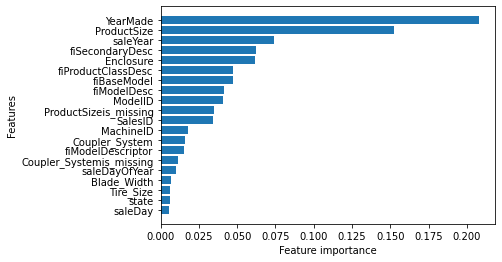

In [88]:
plot_features(X_train.columns, ideal_model.feature_importances_)